In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import folium
from elasticsearch import Elasticsearch

from helper_functions import load_json_file, list_in_bin_at_time, read_file, find_common_strings

# bbox preiskovane regije (Ljubljana in Celje z okolico)
lon_min = 14.45 
lon_max = 15.35 
lat_min = 45.87 
lat_max = 46.28

In [5]:
ELASTIC_USERNAME =  # INSERT YOUR USERNAME
ELASTIC_PASSWORD =  # INSERT YOUR PASSWORD


hosts = ["https://eestec2024.cl-test.medius.si:9200"]
# How many samples the query returns (maximum is 10000) if you want more use scroll
number_of_samples = 10

In [6]:
# Connect to the Elasticsearch cluster
es = Elasticsearch(
    hosts,
    ssl_show_warn=False,  # Suppress SSL warnings, use with caution
    verify_certs=False,  # This skips SSL certificate verification
    http_auth=(ELASTIC_USERNAME, ELASTIC_PASSWORD)  # Include if your Elasticsearch has authentication enabled
)

/tmp/ipykernel_27107/1703270324.py:2: DeprecationWarning: The 'http_auth' parameter is deprecated. Use 'basic_auth' or 'bearer_auth' parameters instead
  es = Elasticsearch(


In [ ]:
kraji = ["Ljubljana", "Celje", "Grosuplje", "Litija"]

def tagify(tup):
    return {"lat": tup[0], "lon": tup[1]}
geoloc = {tagify(osm.geocoder.geocode(kraj)) for kraj in kraji}


# poiščemo id-je ljudi v posameznem kraju podnevi/ponoči

for kraj in kraji:
    for time_mode in ["podnevi","ponoci"]:

        s = list_in_bin_at_time(geoloc[kraj]["lat"]-0.05,
                                geoloc[kraj]["lat"]+0.05,
                                geoloc[kraj]["lon"]-0.07,
                                geoloc[kraj]["lon"]+0.07,
                                time_mode=time_mode)

        with open(kraj+"_ids_"+time_mode+".txt", "w") as f:
            f.write(str(s))

In [ ]:
# poiščemo dnevne migrante na relaciji Celje - Ljubljana - Celje

file1 = 'Celje_ids_ponoci.txt'
file2 = 'Ljubljana_ids_podnevi.txt'

common_strings = find_common_strings(file1, file2)
print("Common strings found in both files:")
for string in common_strings:
    print(string)

In [ ]:
# s spletne strani Avtobusne postaje Ljubljana smo z extract_bus_times.js izluščili
# pare časov in postaj za linije na relaciji Ljubljana - Celje (postaje_raw.txt)

# postaje opremimo z geolokacijami

ll = []
with open("postaje_raw.txt","r") as f:
    for line in f:
        l = list(map( lambda x : x.strip("[]"), f.readline().strip("[]\n").replace("\"","").split(",")))
        if len(l) <= 1:
            break
        print(l)

        l2 = []
        for i in range(0,len(l),2):
            ime_postaje = l[i]
            (lat, lon), is_bus_stop = ime_to_lat_lon(ime_postaje)
            if not is_bus_stop:
                print("not bus stop, couldnt find => skip", ime_postaje)
                continue
            time =  dateTime_to_hours(l[i+1])
            l2.append((time,lat,lon))
        ll.append(l2)

In [419]:
# to je generator id-jev iz datoteke
# vrača enega po enega

def gen(file = "pravi.txt"):
    with open(file) as f:
        for id in f.read().strip("[]\{\}").split(", "):
            yield id.strip("\"'")
            
g = gen()

In [397]:
STOPS = [(11.916666666666666, 46.057711, 14.5095422),
  (12.0, 46.0693955, 14.51045),
  (12.133333333333333, 46.1188983, 14.5509658),
  (12.333333333333334, 46.14970815, 14.627597706566844),
  (12.35, 46.1332709, 14.6527691),
  (12.4, 46.1625428, 14.6644837),
  (12.5, 46.1669606, 14.7456955),
  (12.583333333333334, 46.176147, 14.8023577),
  (12.7, 46.1855529, 14.8596076),
  (12.716666666666667, 46.183128, 14.8671746),
  (12.733333333333333, 46.1882207, 14.8861224),
  (12.883333333333333, 46.2279699, 14.9428702),
  (12.933333333333334, 46.2432712, 14.9502677),
  (12.95, 46.2514797, 14.9587649),
  (13.116666666666667, 46.2536185, 15.0437898),
  (13.2, 46.2471353, 15.0947316),
  (13.233333333333333, 46.2592717, 15.114259449951076),
  (13.266666666666667, 46.2577453, 15.1159325),
  (13.35, 46.2517774, 15.1632057),
  (13.4, 43.8572331, 18.3840898),
  (13.433333333333334, 46.2453212, 15.188509),
  (13.45, 46.2443389, 15.19936007975388),
  (13.483333333333333, 46.2407484, 15.217976),
  (13.516666666666667, 46.23627385, 15.246885643231641),
  (13.55, 46.2524943, 15.2055276),
  (13.566666666666666, 46.2323127, 15.2546041),
  (13.583333333333334, 46.2341969, 15.260901),
  (13.633333333333333, 46.2293889, 15.2616828)]

da768d9ab7f105cbc9aba215dbb2fb58ef83af31a9b03c393ac052683bb53f1c
488
488
(488, 3)


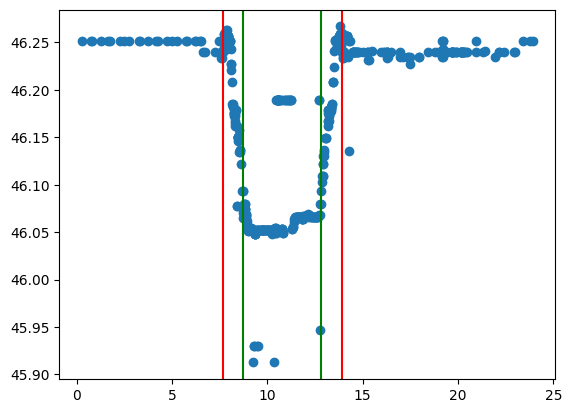

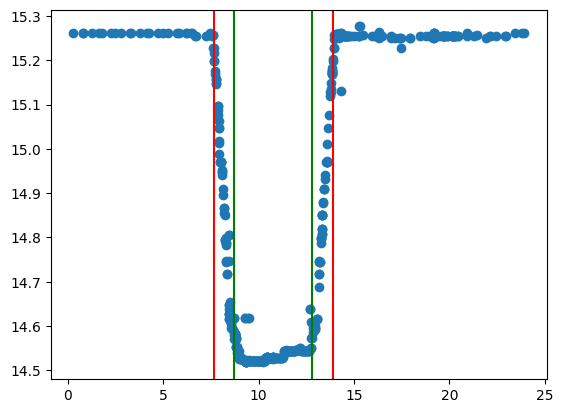

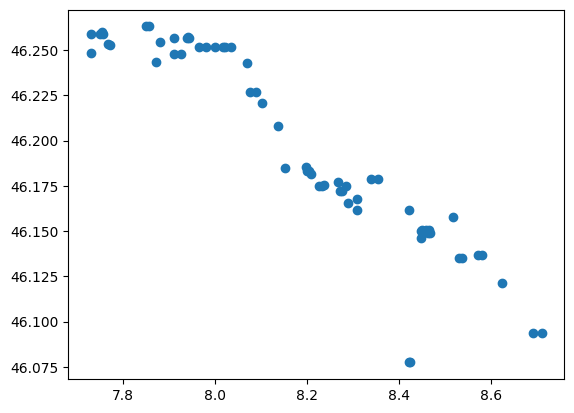

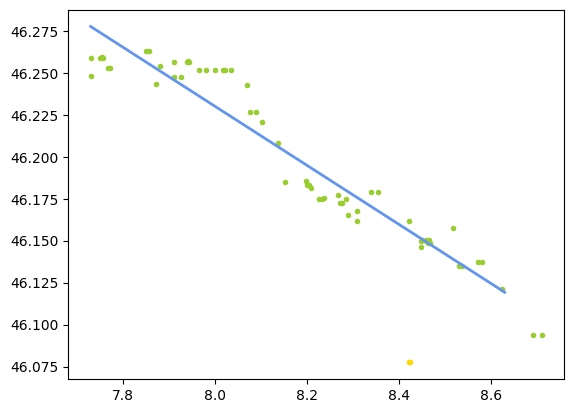

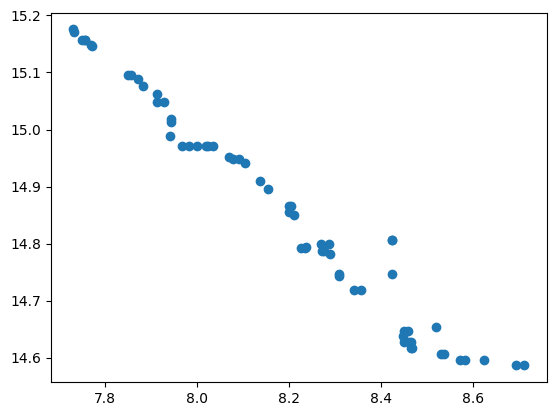

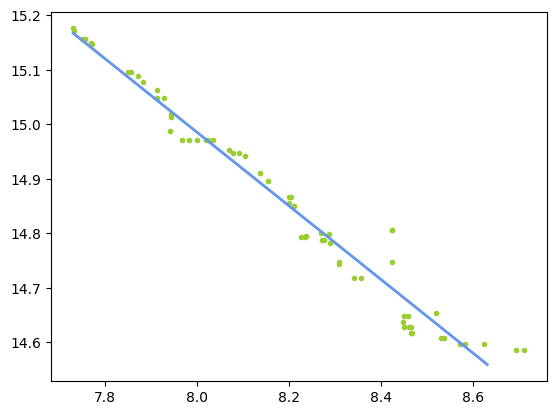

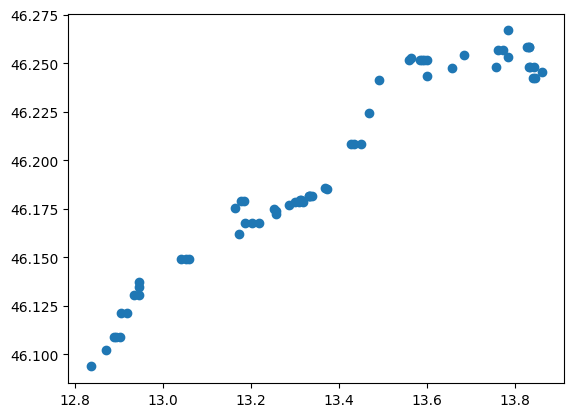

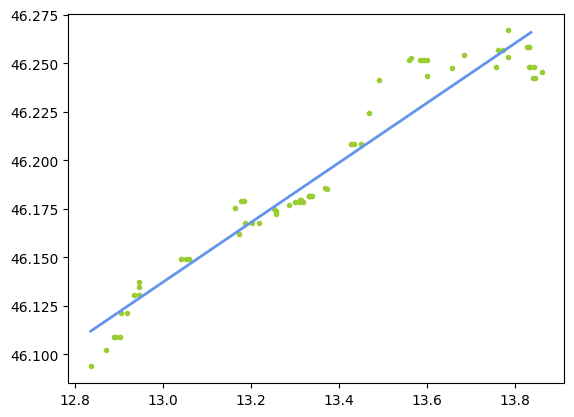

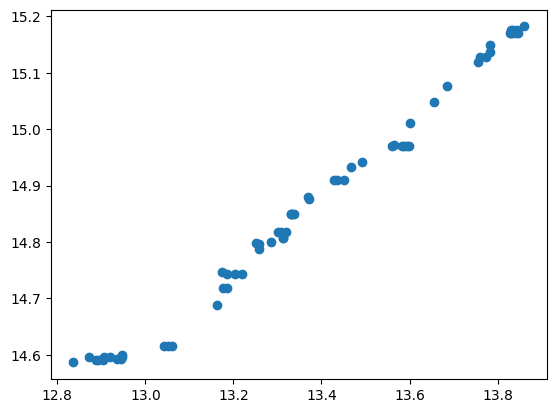

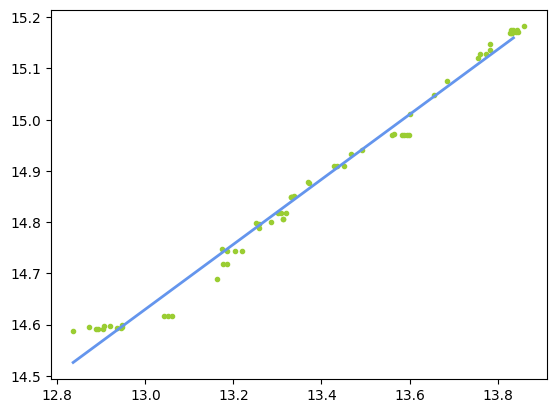

v1:  [55.52229806] v2:  [51.70527577]


In [422]:
# vsak klic te celice izriše drugega uporabnika

m = None
d = geoloc

for id in g:
    print(id)
    m, r = visualize(id,stops = STOPS)

    # poiščemo prve točke, ko je naprava zapustila/prispela v kraj
    kraj = "Celje"
    lat_min, lat_max, lon_min, lon_max = (
        d[kraj]["lat"] - 0.05,
        d[kraj]["lat"] + 0.05,
        d[kraj]["lon"] - 0.07,
        d[kraj]["lon"] + 0.07,
    )
    cutCE = cuts(lat_min, lat_max, lon_min, lon_max, id=id, mode="101")

    kraj = "Ljubljana"
    lat_min, lat_max, lon_min, lon_max = (
        d[kraj]["lat"] - 0.05,
        d[kraj]["lat"] + 0.05,
        d[kraj]["lon"] - 0.07,
        d[kraj]["lon"] + 0.07,
    )
    cutLJ = cuts(lat_min, lat_max, lon_min, lon_max, id=id, mode="010",r=r)
    
    
    if True:
        data = [
            (
                dateTime_to_hours(e["dateTimeEvent"]),
                e["location"]["lat"],
                e["location"]["lon"],
            )
            for e in r
        ]
        data = np.array(data)
        print(data.shape)
        try:
            plt.scatter(data[:, 0], data[:, 1])
            plt.axvline(x = cutCE[0], color = 'r')
            plt.axvline(x = cutLJ[0], color = 'g')
            plt.axvline(x = cutCE[1], color = 'r')
            plt.axvline(x = cutLJ[1], color = 'g')
            plt.show()
            
            plt.scatter(data[:, 0], data[:, 2])
            plt.axvline(x = cutCE[0], color = 'r')
            plt.axvline(x = cutLJ[0], color = 'g')
            plt.axvline(x = cutCE[1], color = 'r')
            plt.axvline(x = cutLJ[1], color = 'g')
            plt.show()
        except Exception:
            continue
    
        plt.show()
    

    df = pd.DataFrame(data,columns=["time","lat","lon"])
    df = df.sort_values(by=['time'])

    # klancki
    points1 = df[(cutCE[0]<df["time"]) & (cutLJ[0]>df["time"])]
    points2 = df[(cutLJ[1]<df["time"]) & (cutCE[1]>df["time"])]
    
    k1lat = RANSAC(points1,"lat")
    plt.show()
    k1lon = RANSAC(points1,"lon")
    plt.show()
    k2lat = RANSAC(points2,"lat")
    plt.show()
    k2lon = RANSAC(points2,"lon")
    plt.show()

    # k1lat,k1lon,k2lat,k2lon
    # iz lat in lon komponent izračunamo hitrosti na avtocesti
    v1 = None
    v2 = None
    if k1lat is not None and k1lon is not None:
        v1 = np.sqrt(k1lat**2 + k1lon**2)
    
    if k2lat is not None and k2lon is not None:
        v2 = np.sqrt(k2lat**2 + k2lon**2)

    
    print("v1: ", v1,"v2: ",v2)

    break
m

Lokacije (ne črno) se ne skladajo s prihodi avtobusa na postaje (črno), zato lahko sklepamo, da ni potoval z avtobusom.